# Notebook 2 - GAN Training and D1 Sharpening
This notebook will implement and train an image sharpening GAN that will learn to sharpen images from 32x32 pixels to 128x128 pixels.

The data that will be used to train this GAN will be imported cats vs dogs from notebook 1, this is the cleaned 32x32 low resolution (LR) and 128x128 high resolution (HR) datasets.
Within this notebook, two initial 32x32 to 128x128 pixel image sharpening GANs will be trained for 5 epochs, where each GAN will be been trained on different fraction of the total images from the cats vs. dogs dataset. The aim of this experiment is to help determine if more training data results in a better performing GAN. This is necessary as all of the ~23,000 images in the cats vs dogs data cannot be used for training the GAN, as sufficient data needs to be put aside for training several neural network classifiers in notebook 3. The more data available to the neural network classifiers, the better they will perform.

Peak signal-to-noise ratio (PSNR) image sharpening metrics will be calculated for each GAN that was trained on different fractions of the cats vs dogs data, allowing an informed decision to be made on the amount of training data that is required for optimal GAN image sharpening performance. Then, the final image sharpening GAN will be trained with the selected amount of data for 20 epochs. The final trained GAN model will be used to sharpen the left over portion of the cats vs dogs dataset that was not used for training the GAN initially. 

Both the image sharpening GAN trained model and the remainder of the cats vs dogs data which was sharpened using the same GAN, will be outputs from this notebook.

**Note:** This notebook was executed using a GPU, as training the GAN would take many more hours with a CPU.

**Image Sharpening GAN use policy:** Do not use the image sharpening GAN from within this notebook without express permission from the owner (github.com/D-Data8) . Please do not use the image sharpening GAN with any inappropriate or illegal images, or images that you do not have permission to sharpen.


# 1. Import Required Libraries and Display Notebook Information

In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation,  Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU, Add, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras import models, layers
import time

In [2]:
# Print out the tensorflow version being used in this notebook environment:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.11.0


In [3]:
# Print out the processor being used for this notebook environment:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11695139516658037626
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16105865216
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11461303153993607006
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

# 2. Load and Inspect the Training Datasets
The datasets required for training the GAN will be loaded in from the output of notebook 1, which are listed below:
* **Dataset 1:** Cats vs dogs cleaned low resolution (LR) 32x32 pixel dataset containing 22770 images.
* **Dataset 2:** Cats vs dogs cleaned high resolution (HR) 128x128 pixel dataset containing 22770 images.

**Note:** both dataset 1 and dataset 2 contain the same images, so these datasets combined create the LR/HR image pairs that are required to train the image sharpening GAN. It is also worth noting that image labels are not required for training the GAN, only the LR/HR image pairs are needed. 

In [7]:
# Display the files present in the notebook input directory:
!ls -1 ../input/1-cats-dogs-data-prep-v1


__notebook__.ipynb
__notebook_source__.ipynb
__output__.json
__results__.html
__results___files
custom.css
images_hr.npz
images_lr.npz
labels.npz


In [8]:
# Load the notebook 1 output datasets into variables:
lr_npz = np.load("../input/1-cats-dogs-data-prep-v1/images_lr.npz")
hr_npz = np.load("../input/1-cats-dogs-data-prep-v1/images_hr.npz")
labels_npz = np.load("../input/1-cats-dogs-data-prep-v1/labels.npz")

# 2.1 Dataset Metrics

In [9]:
# Print some metrics on the imported image datasets:
images_lr = lr_npz['arr_0']
images_hr = hr_npz['arr_0']
labels = labels_npz['arr_0']

print("images_lr shape:", np.shape(images_lr), ", max pixel:", np.max(images_lr), ", min pixel:", np.min(images_lr))
print("images_hr shape:", np.shape(images_hr), ", max pixel:", np.max(images_hr), ", min pixel:", np.min(images_hr))
print("labels shape:", np.shape(labels))

images_lr shape: (22770, 32, 32, 3) , max pixel: 255 , min pixel: 0
images_hr shape: (22770, 128, 128, 3) , max pixel: 255 , min pixel: 0
labels shape: (22770,)


From the output of the above cell it can be seen that the dataset shapes look correct for the LR and HR datasets. Additionally, the pixel values are in the range of [0,255], so these will need to be scaled into the range of [0,1] as they are passed into the GAN for training. Next, some the LR/HR imges will be visualised.

# 2.2 Dataset Visualisation

In [11]:
# Define a dictionary for the image label text:
cats_dogs_label_names = {0:'Cat', 1:'Dog'}

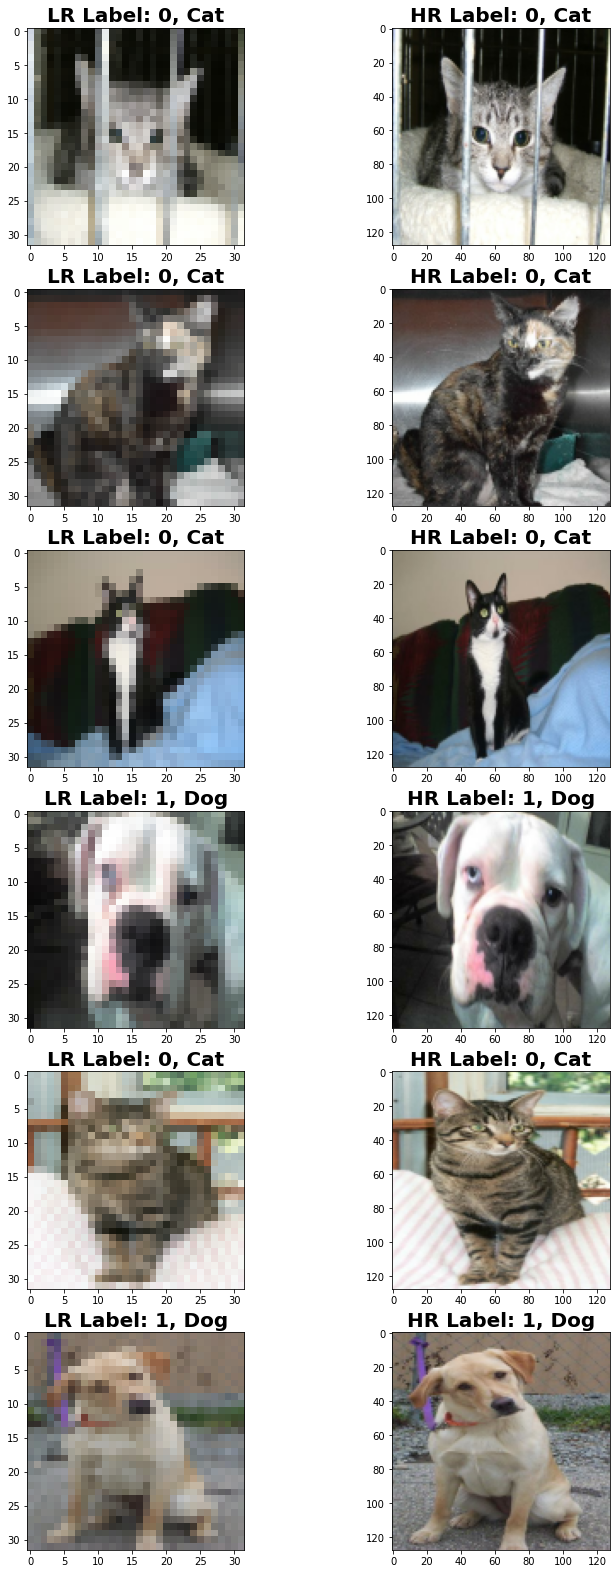

In [12]:
# Plot some of the LR and HR image data and associated labels:   
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(12,28))
np.random.seed(7889)
for image in range(0, 11, 2):
    random_index = int(np.random.randint(low = 1, high = len(images_lr), size = 1))
    plt.subplot(6,2,image+1)
    plt.imshow(images_lr[random_index])
    label = int(labels[random_index]) 
    label_text = cats_dogs_label_names[label]
    plt.title("LR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')
    plt.subplot(6,2,image+2)
    plt.imshow(images_hr[random_index])
    plt.title("HR Label: {}, {}".format(label, label_text), fontsize=20, fontweight='bold')

From the images shown in the cell above the LR and HR image pairs all look correct and the images are synchronised in both datasets. This should give enough confidence in the data having been loaded correctly into this environment for training the GAN.

Next, the dataset will be indexed with different split fractions for each of the 2 preliminary GAN models that will be trained. 

# 3. Partitioning the Data and GAN Training
It is not known at this stage how much data will be required to train the GAN for best image sharpening performance. Due to this, 2 preliminary GANs will be trained for several epochs each to save processing power, with one GAN being trained on a larger portion of the cats vs dogs data. The fractions of the full dataset that will be used to train each GAN are 50% and 75%. The PSNR Image sharpening metric will be introduced later in this section that will help to quantify the image sharpening ability of each GAN, so an informed decision can be made. 

After the final data fraction has been decided for training the GAN, the GAN will be retrained with the selected data fraction, for many more epochs with the aim of producing a robust 4x resolution image sharpening GAN that will sharpen colour images from 32x32 pixels to 128x128 pixels.

# 3.1 Data Split Fractions

In [7]:
# Split up the training Data for training 2 different models:
splits = [0.5, 0.75]
split_dict = {}
for index, element in enumerate(splits):
    split_dict["train_split_" + str(index)] = int(element*(len(images_lr)))
print(split_dict)

{'train_split_0': 11385, 'train_split_1': 17077}


# 3.2 GAN Training 
Now that the data split fractions are defined, the the GAN training code will be implemented. The GAN will consist of 2 neural network models, called the generator and the discriminator, which will be trained together in an adversarial manner. LR and HR image pairs will be fed into the GAN one at a time, where the GAN will learn how to create a sharper version of the LR image.

The implementation of this GAN in this notebook was inspired from the 2017 paper by Ledig et al. **[1]**. The implementation of parts of the GAN traing python code in this notebook was inspired by the work of S. Bhattiprolu, 2022 **[2]** and J. Lai Hong, 2021 **[3]**.

## 3.3 Discriminator Model
This model architecture is exactly as explained in the paper by Christian Ledig et al. **[1]**.

In [2]:
# Discriminator Neural Network Model:   
d_model = models.Sequential()
d_model.add(layers.Conv2D(filters=64,kernel_size=(3, 3),strides=(1,1),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
# Discriminator Blocks:
d_model.add(layers.Conv2D(filters=64,kernel_size=(3, 3),strides=(2,2),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.BatchNormalization(momentum=0.5))
d_model.add(layers.Conv2D(filters=128,kernel_size=(3, 3),strides=(1,1),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.BatchNormalization(momentum=0.5))
d_model.add(layers.Conv2D(filters=128,kernel_size=(3, 3),strides=(2,2),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.BatchNormalization(momentum=0.5))
d_model.add(layers.Conv2D(filters=256,kernel_size=(3, 3),strides=(1,1),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.BatchNormalization(momentum=0.5))
d_model.add(layers.Conv2D(filters=256,kernel_size=(3, 3),strides=(2,2),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.BatchNormalization(momentum=0.5))
d_model.add(layers.Conv2D(filters=512,kernel_size=(3, 3),strides=(1,1),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.BatchNormalization(momentum=0.5))
d_model.add(layers.Conv2D(filters=512,kernel_size=(3, 3),strides=(2,2),padding='same',
                          input_shape=(128,128,3), activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.BatchNormalization(momentum=0.5))

# Flatten and connect to a classifier output:
d_model.add(layers.Flatten())
d_model.add(layers.Dense(1024, activation=LeakyReLU(alpha=0.2)))
d_model.add(layers.Dense(1, activation='sigmoid'))
d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       1

## 3.4 Generator Model
This model architecture is exactly as explained in the paper by Christian Ledig et al. **[1]**. The functional API method had to be used to build the generator model due to the existance of residual blocks within the network.

In [3]:
# Generator Model Neural Network Model:
def generator_residual_block(block_input, b_norm):
    res_block = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(block_input)
    if b_norm == True: res_block = BatchNormalization(momentum=0.5)(res_block)
    res_block = Activation('PReLU')(res_block) 
    res_block = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(res_block)
    if b_norm == True: res_block = BatchNormalization(momentum=0.5)(res_block)      
    res_block_output = Add()([block_input, res_block])
    return res_block_output

def Generator():
    L1_input = Input(shape=(32,32,3))
    L2 = Conv2D(filters = 64, kernel_size = (9, 9), strides = (1, 1), padding = 'same')(L1_input)
    L4 = Activation('PReLU')(L2)
    B1_input = L4
    
    # 5x Residual Blocks:
    B1_output = generator_residual_block(B1_input, b_norm=True)
    B2_output = generator_residual_block(B1_output, b_norm=True)
    B3_output = generator_residual_block(B2_output, b_norm=True)
    B4_output = generator_residual_block(B3_output, b_norm=True)
    B5_output = generator_residual_block(B4_output, b_norm=True)
    
    # Post Residual Block:
    L5 = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(B5_output)
    L6 = BatchNormalization(momentum=0.5)(L5)
    L7 = Add()([L6, B1_input])
    
    # 2X Upsampling blocks:
    L8 = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(L7)
    L9 = UpSampling2D(size=(2,2))(L8) # PixelShuffler X2
    L10 = Activation('PReLU')(L9)
    L11 = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(L10)
    L12 = UpSampling2D(size=(2,2))(L11) # PixelShuffler X2
    L13 = Activation('PReLU')(L12)   
    
    L14 = Conv2D(filters = 3, kernel_size = (9, 9), strides = (1, 1), padding = 'same')(L13)
    
    generator_model = Model(inputs=L1_input, outputs=L14)
    return generator_model

In [4]:
generator_model = Generator()
generator_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   65536       ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 64)   36928       ['activation[0][0]']             
                                                                                              

It can be seen from the generator model summary that the model has over 6.8 million traininable parameters, indicating that this is a large neural network model. 
The untrained generator and discriminator models will be firstly saved, so that the untrained model can be reloaded for each new instance of the GAN that will be trained on a different proportion of the dataset. This should prevent any trained parameters being retained when new models begin training.

## 3.5 Saving the Untrained Models

In [12]:
# Save the untrained generator model:
generator_model.save("./cats_dogs_untrained_generator.h5")
# Save the untrained discriminator model:
d_model.save("./cats_dogs_untrained_discriminator.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2023-02-22 10:07:21.398093: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


## 3.6 Loss Functions and VGG19 Model

In [13]:
def calculate_generator_loss(sr_out):
    return BinaryCrossentropy()(tf.ones_like(sr_out), sr_out)

def calculate_discriminator_loss(hr_out, sr_out):
    hr_loss = BinaryCrossentropy()(tf.ones_like(hr_out), hr_out)
    sr_loss = BinaryCrossentropy()(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

Import part of the VGG19 model, which will be used for calculating the content loss of the sharpened images. The layer activation output from the model can be used to infer the effect of the image sharpening as it improves during training the GAN.

In [14]:
from tensorflow.keras.applications.vgg19 import VGG19
# VGG19 pre-trained model:
vgg = VGG19(input_shape=(128, 128, 3), include_top=False)
VGG19_model = Model(vgg.input, vgg.layers[10].output) # Use 10 layers of the model
VGG19_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________________

## 3.7 GAN Training
The code in the next cell will actually implement the GAN training using all of the previously defined functions. The implementation of this GAN training code with the tf.GradientTape() method was inspired from the published TensorFlow Deep Convolutional Generative Adversarial Network tutorial **[4]**, with additional inspiration taken from the approaches of S. Bhattiprolu, 2022 **[2]** and J. Lai Hong, 2021 **[3]**.

In [14]:
# Iterate through the 2 experiments and train a new model for each data split:
for key in split_dict:
    print("---------- Training {} ----------".format(key))
    # Load the generator untrained model:
    generator_model = tf.keras.models.load_model('cats_dogs_untrained_generator.h5')
    d_model = tf.keras.models.load_model("./cats_dogs_untrained_discriminator.h5")
    split = split_dict[key]
    train_lr = images_lr[:split]
    train_hr = images_hr[:split]
    print("split:", split)
    print("len(train_lr):", len(train_lr))
    print("len(train_hr):", len(train_hr))

    # Train the GAN: 
    # Firstly list the @tf.functions which are compiled before each iteration
    ####################################################################
    @tf.function
    def train_step(lr, hr, generator_model, d_model ):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = generator_model(lr, training=True) # Generate a SR image

            hr_output = d_model(hr, training=True) # HR image Discriminator loss
            sr_output = d_model(sr, training=True) # SR image Discriminator loss

            con_loss = calculate_content_loss(hr, sr)
            gen_loss = calculate_generator_loss(sr_output)
            perc_loss = con_loss + 0.001 * gen_loss # From the 2017 paper by Ledig et al. [1]
            disc_loss = calculate_discriminator_loss(hr_output, sr_output)

        gradients_of_generator = gen_tape.gradient(perc_loss, generator_model.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, d_model.trainable_variables) 

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))

        return perc_loss, disc_loss

    @tf.function
    def calculate_content_loss(hr, sr):
        sr_features = VGG19_model(sr) / 12.75 # This ensures the scale is the same, C. Ledig et al. [1]
        hr_features = VGG19_model(hr) / 12.75 # This ensures the scale is the same, C. Ledig et al. [1]
        return MeanSquaredError()(hr_features, sr_features)
    ##########################################################################
    
    generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5) 
    discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5) 
    start = time.time()

    epochs = 5
       
    for epoch in range(epochs):
        epoch_start = time.time()
         
        g_losses = [] # Generator Loss
        d_losses = [] # Discriminator Loss
        
        # Iterate over each LR/HR image pair:
        for index in range(len(train_lr)):
            lr_image = images_lr[index] # Get LR image
            # Implement the 0-1 range image pixel value transformation for the LR images:
            lr_image = lr_image.astype(float) / 255.0 # Scale the image pixel values into range [0,1]
            lr_image = np.expand_dims(lr_image, axis=0) # Add the batch dimension of 1

            hr_image = train_hr[index] # Get HR image
            # Implement the [0,1] range image pixel value transformation for the HR images:
            hr_image = hr_image.astype(float) / 255.0 # Scale the image pixel values into range [0,1]
            hr_image = np.expand_dims(hr_image, axis=0) # Add the batch dimension of 1
            
            # Pass the images into train_step and return the losses:
            vgg19_loss, discriminator_loss = train_step(lr_image, hr_image, generator_model, d_model)

            # Append train_step losses to the lists defined above: 
            d_losses.append(discriminator_loss)
            g_losses.append(vgg19_loss)
   
        g_losses = np.array(g_losses)
        d_losses = np.array(d_losses)

        # Average the loss over the array:
        g_loss = np.sum(g_losses, axis=0) / len(g_losses)
        d_loss = np.sum(d_losses, axis=0) / len(d_losses)

        # Print out epoch metrics during GAN training: 
        print("epoch:", epoch ,"g_loss:", g_loss, "d_loss:", d_loss)

        # Print out the training duration for each epoch:
        epoch_end = time.time() 
        epoch_training_mins = (epoch_end - epoch_start)/60
        print("Epoch {} took {} minutes".format(epoch, epoch_training_mins))
    
    # Save each trained model:
    generator_model.save("./cat_dog_{}_images2_trained_generator_{}_epochs.h5".format(str(split), epochs))
    print("Model {} Saved".format(key))   
    
    # Reset training variables so that the new model is trained from scratch:
    tf.keras.backend.clear_session()

---------- Training train_split_0 ----------
split: 11385
len(train_lr): 11385
len(train_hr): 11385


2023-02-20 16:10:41.329029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-20 16:10:43.440986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


epoch: 0 g_loss: 0.18564255839646465 d_loss: 0.8359266064174352
Epoch 0 took 7.38798885345459 minutes
epoch: 1 g_loss: 0.13698654342336408 d_loss: 0.24787249190272287
Epoch 1 took 7.177247524261475 minutes
epoch: 2 g_loss: 0.12749984131395475 d_loss: 0.24825192310331576
Epoch 2 took 7.165260354677836 minutes
epoch: 3 g_loss: 0.1224336713774978 d_loss: 0.2661664625192139
Epoch 3 took 7.100538742542267 minutes
epoch: 4 g_loss: 0.11790707688296004 d_loss: 0.23835664731554676
Epoch 4 took 7.097786339124044 minutes
Model train_split_0 Saved
---------- Training train_split_1 ----------
split: 17077
len(train_lr): 17077
len(train_hr): 17077
epoch: 0 g_loss: 0.1703971464725947 d_loss: 0.664478126646952
Epoch 0 took 10.697685392697652 minutes
epoch: 1 g_loss: 0.13096333884757275 d_loss: 0.25288533988515255
Epoch 1 took 10.624477430184681 minutes
epoch: 2 g_loss: 0.12262635896417697 d_loss: 0.25225137772113077
Epoch 2 took 10.613112998008727 minutes
epoch: 3 g_loss: 0.11728984119951177 d_loss: 0

Now that the first GAN models are trained, it would be useful to sharpen some images with each GAN and visualise these.

## 3.8 Sharpening Images With the Trained GAN
At this initial stage, some images will be sharpened with one of the trained GANs and visualised, to inpsect that the sharpened images look correct.

In [25]:
# Sharpen 20 unseen images from the end of the images_lr dataset for the purpose of visualising the results:
generator = tf.keras.models.load_model('/kaggle/working/cat_dog_17077_images2_trained_generator_5_epochs.h5')
sharpened = generator.predict(np.float32(images_lr[-20:] / 255))

# Print out some metrics on the sharpened images:
print("Sharpened set shape:", np.shape(sharpened))
print("Sharpened set min pixel value:", np.min(sharpened), ", Sharpened set max pixel value:", np.max(sharpened))

Sharpened set shape: (20, 128, 128, 3)
Sharpened set min pixel value: -0.14036475 , Sharpened set max pixel value: 1.1763203


From the output of the above cell, it can be seen that the GAN output sharpened images are no longer in the range [0,1], as some pixel values fall slightly outside this range. The solution is to clip the values to 0 and 1, as these pixel thresholds correspond to the red, green and blue (RGB) pixel colour limits.

In [23]:
sharpened = tf.clip_by_value(sharpened, 0 ,1)
print("Sharpened set shape:", np.shape(sharpened))
print("Sharpened set min pixel value:", np.min(sharpened), ", Sharpened set max pixel value:", np.max(sharpened))

Sharpened set shape: (20, 128, 128, 3)
Sharpened set min pixel value: 0.0 , Sharpened set max pixel value: 1.0


From the output, above it can be seen that the sharpened images now have pixel values that lie in the range [0,1]. These images will be plotted next, to verify that they look correct compared to the corresponding LR and HR images.

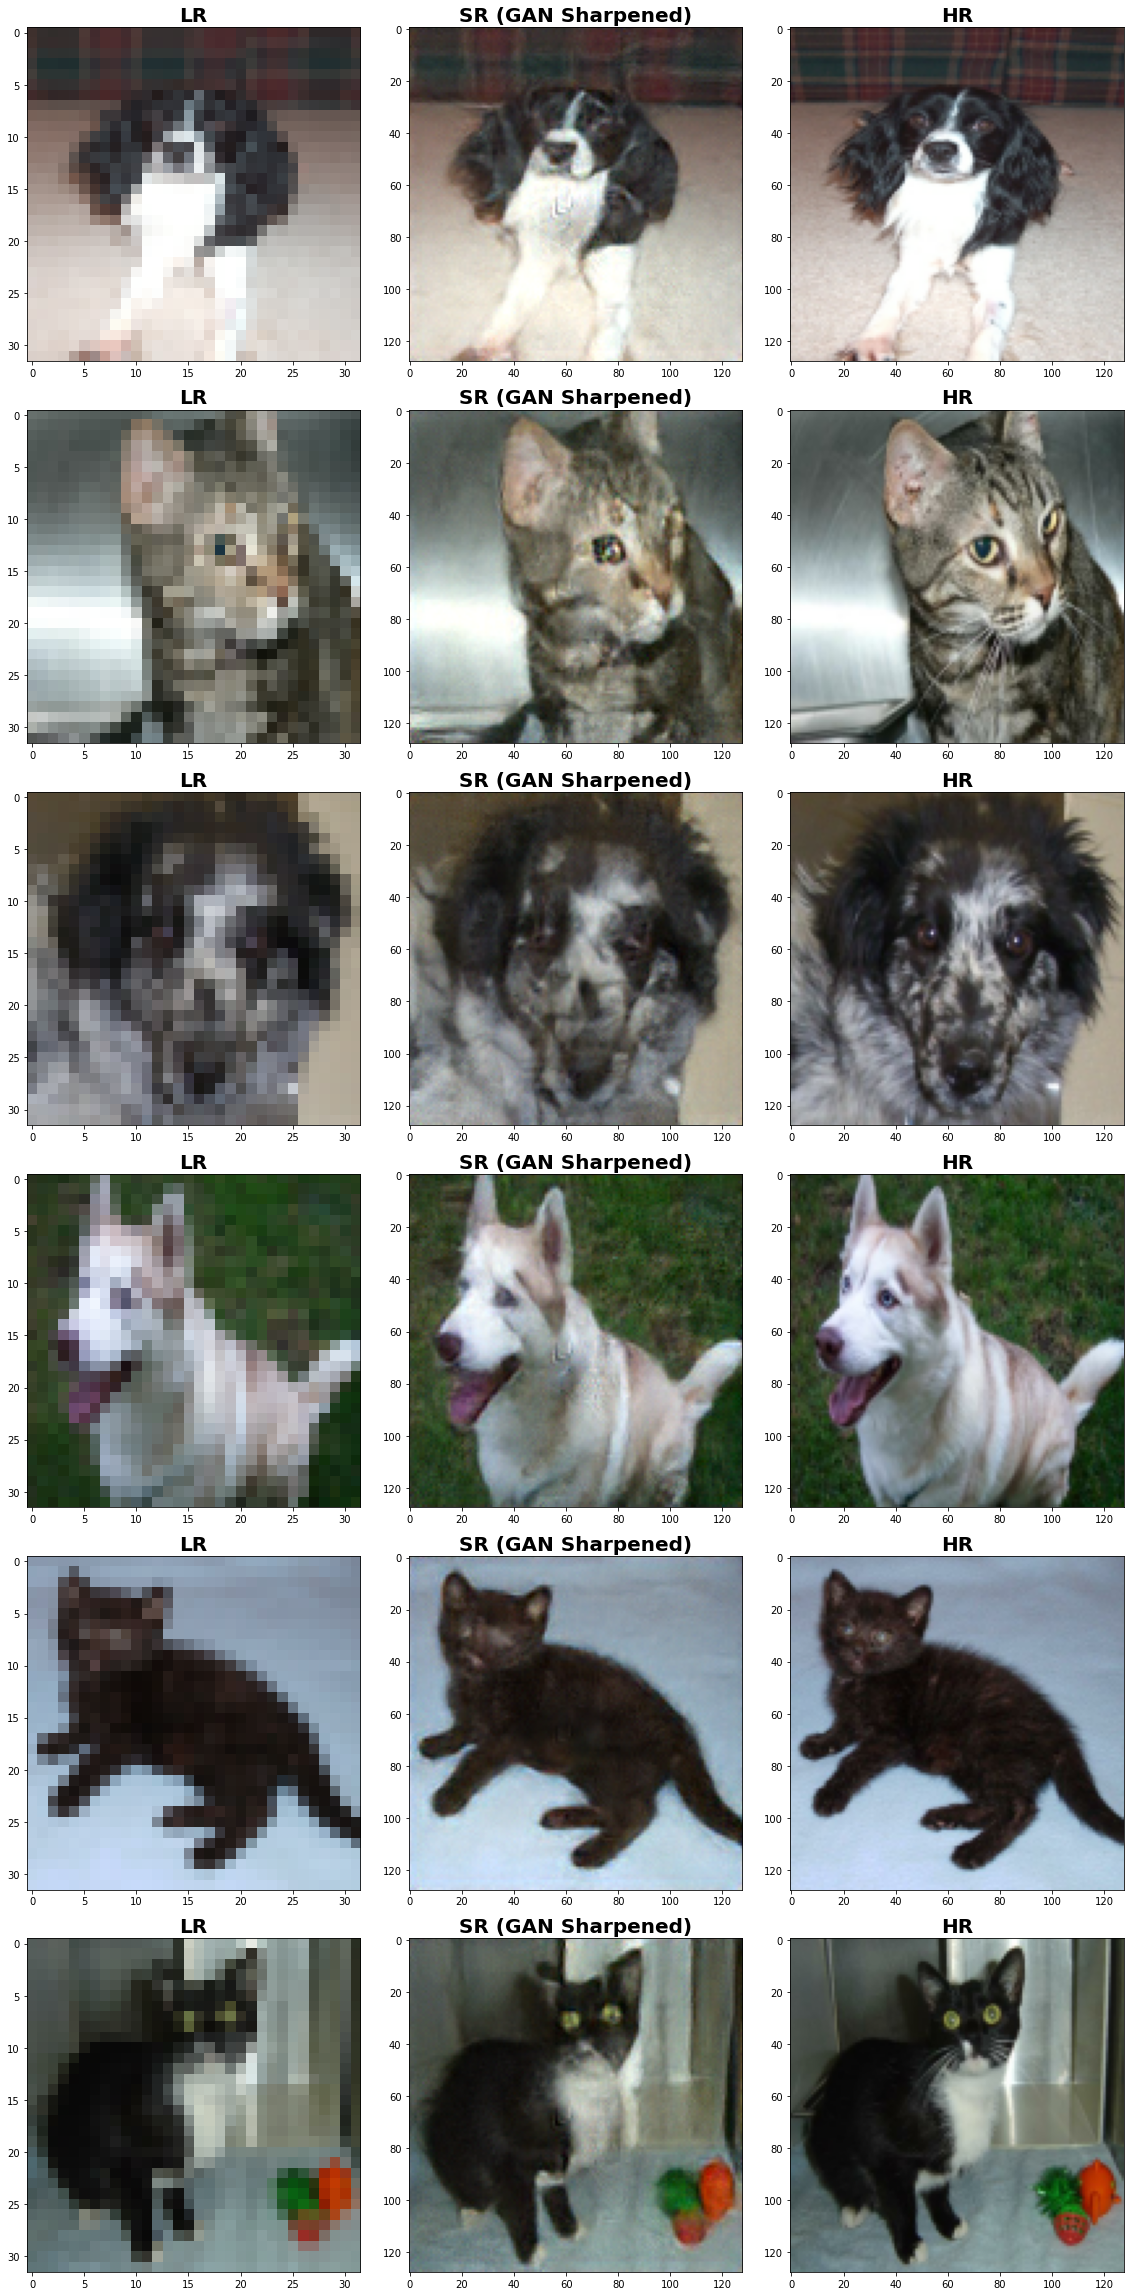

In [26]:
#Plot a few images from LR, SR and HR datasets to verify that the image sharpening has worked as expected:
fig, ax = plt.subplots(nrows=6,ncols=3, figsize=(16,32))
for image in range(0, 17, 3):
    plt.subplot(6,3,image+1)
    plt.imshow(images_lr[-20:][image])
    plt.title("LR", fontsize=20, fontweight='bold')
    plt.subplot(6,3,image+2)
    plt.imshow(sharpened[-20:][image])
    plt.title("SR (GAN Sharpened)", fontsize=20, fontweight='bold')
    plt.subplot(6,3,image+3)
    plt.imshow(images_hr[-20:][image])
    plt.title("HR", fontsize=20, fontweight='bold')
    fig.tight_layout()

From the images shown in the previous cell, it is clear that the image sharpening GAN is working as expected. The image resolution has increased from 32x32 pixels to 128x128 pixels and the image appears much sharper compared to the LR 32x32 pixel image. Next, it would be useful to attempt to quantify this level of sharpness to evaluate the sharpening performance of each GAN.

# 4. Evaluating GAN Sharpening Performance
Next, the two preliminary trained GAN models will be evaluated at this stage to determine if the larger training dataset results in a GAN that can produce sharper images. For this, an image sharpness metric will need to be utilised to allow meaningful comparisons to be made. The peak signal-to-noise (PSNR) metric can be used to score images that have a high quality reference image available, such as with the cats_vs_dogs dataset where the 128x128 pixel downsised HR image can be used for comparison. Therefore, the PSNR metric should allow a GAN sharpness score to be generated for each image that was sharpened in this notebook.

## 4.1 Reference Image Sharpness PSNR Score
The peak signal-to-noise ratio (PSNR) is a method of calculating the sharpness of an image compared to an original reference image. The sharpness score is measured in decibels and a higher score indicates a higher degree of likeness to the original high resolution image. If one image is compared to itself, the PSNR score would be 100dB.

In [15]:
from math import log10, sqrt
def PSNR(original_image, sharpened_image):
    mse = np.mean((original_image - sharpened_image) ** 2)
    if(mse == 0):  # If MSE = 0, both images are the same and a score of 100 is returned
        return 100
    maximum_pixel_value = 1.0
    psnr_score = 20 * log10(maximum_pixel_value / sqrt(mse))
    return psnr_score

In [11]:
model_list = ["cat_dog_11385_images2_trained_generator_5_epochs.h5",
         "cat_dog_17077_images2_trained_generator_5_epochs.h5"]

In [11]:
# Import 2 GAN models and use each to sharpen 100 unseen images, then calculate the PSNR score for each SR image:
sharpened_image_sets = [[],[]]
num_images = 100
psnr_results = pd.DataFrame(columns=["50% of Data", "75% of Data"])
for index, element in enumerate(model_list):
        path = '/kaggle/working/'+ element
        generator = tf.keras.models.load_model(path)
        sharpened_images = generator.predict(
            np.float32(lr_npz["arr_0"][-num_images:] / 255)) # Last few elements
        sharpened_images = tf.clip_by_value(sharpened_images, 0, 1) # Clip output into the range [0,1]
        sharpened_image_sets[index] = sharpened_images
        print("SR MAX:", np.max(sharpened_images), "SR MIN:",np.min(sharpened_images))
        scores = []
        for i, sr_image in enumerate(sharpened_images):
            hr_image = np.float32(hr_npz["arr_0"][-num_images:][i] / 255)
            psnr_score = PSNR(hr_image, sr_image)
            scores.append(psnr_score)
        psnr_results.iloc[:,index] = scores

2023-02-20 21:54:01.567535: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-20 21:54:02.160067: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


SR MAX: 1.0 SR MIN: 0.0
SR MAX: 1.0 SR MIN: 0.0


In [12]:
# Format the results of the PSNR test:
psnr_results = psnr_results.assign(Best_Model = lambda row: (row.idxmax(axis=1)))
psnr_counts = psnr_results["Best_Model"].value_counts()
print(psnr_counts)
percentages_psnr = (psnr_counts["75% of Data"] / psnr_counts.sum()) * 100
print(f'{percentages_psnr:.1f}', "%")
psnr_results

75% of Data    95
50% of Data     5
Name: Best_Model, dtype: int64
95.0 %


50% of Data  75% of Data   Best_Model
0     20.419860    28.106944  75% of Data
1     20.724614    20.984158  75% of Data
2     25.332471    25.273756  50% of Data
3     24.358662    25.031196  75% of Data
4     23.250439    26.142897  75% of Data
..          ...          ...          ...
95    24.764717    24.924784  75% of Data
96    23.277104    23.428288  75% of Data
97    17.145123    23.992246  75% of Data
98    19.595604    26.545800  75% of Data
99    25.453888    25.564952  75% of Data

[100 rows x 3 columns]

It can be seen from the output of the above cell that the model that was trained on 75% of the data resulted in the highest PSNR image sharpness score of 95% of the 100 images tested, compared to the model that was trained on 50% of the data. From these results it is clear that more training data results in a much better performing image sharpening GAN model. Next, images sharpened with each GAN will be shown to allow a visual comparison to be made on the quality.

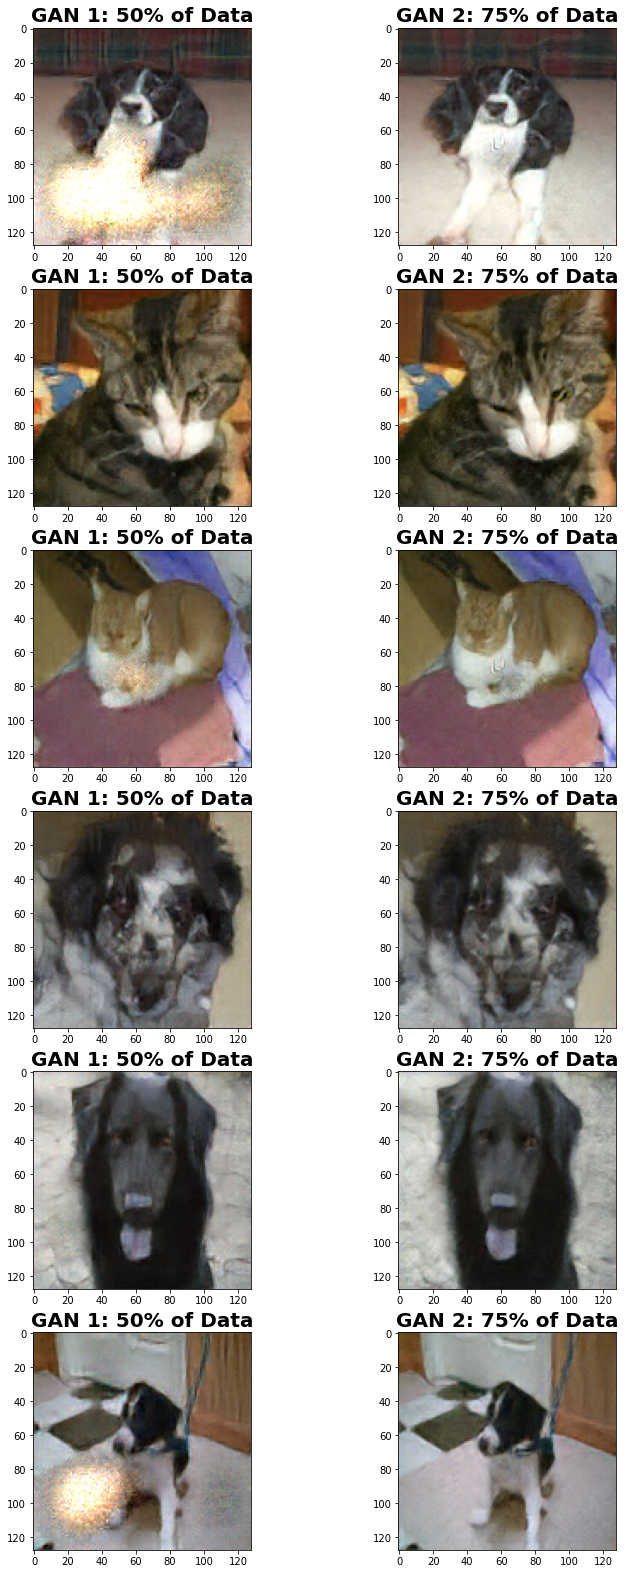

In [20]:
#Plot a few sharpened images from each GAN to inspect the image quality:
fig, ax = plt.subplots(nrows=6,ncols=2, figsize=(12,28))
for image in range(0, 11, 2):
    plt.subplot(6,2,image+1)
    plt.imshow(sharpened_image_sets[0][-20:][image])
    plt.title("GAN 1: 50% of Data", fontsize=20, fontweight='bold')
    plt.subplot(6,2,image+2)
    plt.imshow(sharpened_image_sets[1][-20:][image])
    plt.title("GAN 2: 75% of Data", fontsize=20, fontweight='bold')

It can be seen from the output of the above cell that the images are much sharper and clearer for the GAN that was trained on more data. The GAN that was trained on only 50% of the data appears to show white spots, which are artefacts that image sharpening GANs can introduce into the images it attempts to sharpen. These artefacts are not present in the same images, when sharpened using the GAN that was trained on 75% of the data.

Next, it would be useful to graph the percentage of images where each model obtained the best PSNR score to illuminate if there is a trend.

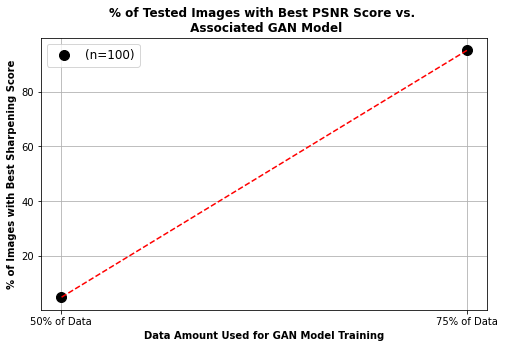

In [17]:
# Plot the percentage of images where each model achieved the best PSNR score:
x_labels = ["75% of Data", "50% of Data"]
y_value = [psnr_counts[x] for x in x_labels]
plt.figure(figsize=(8,5))
plt.plot(x_labels, y_value, 'o', markersize=10, color='black')
plt.plot(x_labels, y_value, linestyle='dashed', color='red')
plt.xlabel("Data Amount Used for GAN Model Training", weight='bold')
plt.ylabel("% of Images with Best Sharpening Score", weight='bold')
plt.title("% of Tested Images with Best PSNR Score vs. \n Associated GAN Model", weight='bold', fontsize=12)
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend( [('(n={})'.format(len(psnr_results)))], fontsize=12)

From the graph above, it is clear that the GAN trained on more data vastly out performs the GAN trained on less data, as the GAN trained on more data resulted in the best PSNR image sharpness score in 95% of the 100 images tested.

Based on the analysis conducted above, 75% of the cats vs dogs data will be used for training the final model for 20 epochs.

# 4.2 Training the final GAN with the selected dataset size
Now that image sharpening metrics have been calculated, the final GAN can be trained for many more epochs, with the chosen dataset size. In this case, the dataset size has to be a balanced choice, as the remaining data will be needed to train an image classifying neural network and too little data left over for this task will impact the neural network performance. **75%** of the cats vs dogs dataset has been chosen for training the final GAN, as this will leave just over 5,600 images to train the neural network classifiers. Due to there only being 2 classes in the cats vs dogs dataset, this should be enough data to allow some meaningful conclusions to be drawn from the image classification in the next stage.

In [16]:
# Now the generator model will be trained for longer with the selected data split:
final_split = int(0.75*(len(images_lr)))
print("Final split size for GAN training:", final_split, "Images")
print("Remaining cats vs dogs images for NN Classifier:", len(images_lr) - final_split, "Images")

Final split size for GAN training: 17077 Images
Remaining cats vs dogs images for NN Classifier: 5693 Images


In [17]:
# Train the GAN model for much longer on the chosen data split:

# Load the untrained models:
generator_model = tf.keras.models.load_model('cats_dogs_untrained_generator.h5')
d_model = tf.keras.models.load_model("./cats_dogs_untrained_discriminator.h5")
train_lr = images_lr[:final_split]
train_hr = images_hr[:final_split]
print("split:", final_split)
print("len(train_lr):", len(train_lr))
print("len(train_hr):", len(train_hr))

# Train the GAN:  
# Firstly list the @tf.functions
####################################################################
@tf.function
def train_step(lr, hr, generator_model, d_model ):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        sr = generator_model(lr, training=True) # Sharpen a LR image to create a SR image

        hr_output = d_model(hr, training=True) # HR image Discriminator loss
        sr_output = d_model(sr, training=True) # SR image Discriminator loss 

        con_loss = calculate_content_loss(hr, sr)
        gen_loss = calculate_generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss  # From the 2017 paper by Ledig et al. [1]
        disc_loss = calculate_discriminator_loss(hr_output, sr_output)

    gradients_of_generator = gen_tape.gradient(perc_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, d_model.trainable_variables) 

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, d_model.trainable_variables))

    return perc_loss, disc_loss

@tf.function
def calculate_content_loss(hr, sr):
    sr_features = VGG19_model(sr) / 12.75 # This ensures the scale is the same, C. Ledig et al. [1]
    hr_features = VGG19_model(hr) / 12.75 # This ensures the scale is the same, C. Ledig et al. [1]
    return MeanSquaredError()(hr_features, sr_features)
##########################################################################
    
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
start = time.time()

epochs = 20
       
for epoch in range(epochs):
    epoch_start = time.time()
 
    g_losses = []
    d_losses = []
        
    # Iterate over each LR/HR image pair one at a time:
    for index in range(len(train_lr)):
        lr_image = images_lr[index] # Get LR image
        lr_image = lr_image.astype(float)/255.0 # Implement the 0-1 range image pixel value transformation:
        lr_image = np.expand_dims(lr_image, axis=0) # Add a batch dimension of 1
        
        hr_image = train_hr[index] # Get HR image
        hr_image = hr_image.astype(float)/255.0 # Implement the 0-1 range image pixel value transformation:
        hr_image = np.expand_dims(hr_image, axis=0) # Add a batch dimension of 1

        # Run train_step with the loaded and transformed LR and HR images:
        vgg19_loss, discriminator_loss = train_step(lr_image, hr_image, generator_model, d_model)
        
        # Append the losses for each image pair:
        d_losses.append(discriminator_loss)
        g_losses.append(vgg19_loss)
    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    # Average the loss over all images within each epoch:
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    # Print out epoch metrics during GAN training: 
    print("epoch:", epoch ,"g_loss:", g_loss, "d_loss:", d_loss)

    # Print out the training duration for each epoch:
    epoch_end = time.time() 
    epoch_training_mins = (epoch_end - epoch_start)/60
    print("Epoch {} took {} minutes".format(epoch, epoch_training_mins))
    
# Save the model:
generator_model.save("./cat_dog_{}_images_trained_generator_{}_epochs.h5".format(str(final_split), epochs))
print("Model Saved")

2023-02-22 10:08:12.373843: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


split: 17077
len(train_lr): 17077
len(train_hr): 17077


2023-02-22 10:08:15.908569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-22 10:08:17.794596: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


epoch: 0 g_loss: 0.1696276824731364 d_loss: 0.6820798693967032
Epoch 0 took 10.89024889866511 minutes
epoch: 1 g_loss: 0.13131751931508753 d_loss: 0.27517697872137964
Epoch 1 took 10.672018301486968 minutes
epoch: 2 g_loss: 0.12253650572132839 d_loss: 0.26301320855536686
Epoch 2 took 10.639359021186829 minutes
epoch: 3 g_loss: 0.11714439617705832 d_loss: 0.23787148490110968
Epoch 3 took 10.710280362764994 minutes
epoch: 4 g_loss: 0.11355251100712947 d_loss: 0.22666616362194034
Epoch 4 took 10.648424224058788 minutes
epoch: 5 g_loss: 0.11063737015384362 d_loss: 0.20274598658374568
Epoch 5 took 10.65110495487849 minutes
epoch: 6 g_loss: 0.10906655390382532 d_loss: 0.20945781652588277
Epoch 6 took 10.635507130622864 minutes
epoch: 7 g_loss: 0.10735408119290567 d_loss: 0.2010192174141389
Epoch 7 took 10.653718129793804 minutes
epoch: 8 g_loss: 0.10581132889129019 d_loss: 0.19546977534201704
Epoch 8 took 10.645510077476501 minutes
epoch: 9 g_loss: 0.10432657732256836 d_loss: 0.1816124752728

In [14]:
# Calculate the PSNR score for the final 20 Epoch trained model:
final_model = 'cat_dog_17077_images_trained_generator_20_epochs.h5'
no_samples = 100
psnr_results_final = pd.DataFrame(columns=["75% of Data (20 Epochs)"])
path = '/kaggle/working/'+ final_model
generator = tf.keras.models.load_model(path)
sharpened_images_final = generator.predict((images_lr[-no_samples:]/255.0))
hr_images = np.float32(images_hr[-no_samples:]/ 255.0)
scores_final = []
for i, sr_image in enumerate(sharpened_images_final):
    sharpened_image = tf.clip_by_value(sr_image, 0, 1) # Clip output into the range [0,1]
    hr_image = hr_images[i]      
    psnr_score = PSNR(hr_image, sharpened_image)
    scores_final.append(psnr_score)

psnr_results_final["75% of Data (20 Epochs)"] = scores_final

In [33]:
# Rename the columns in the 5 epoch trained GAN dataframe results to reflect the amount of epochs:
psnr_results = psnr_results.rename(columns={'50% of Data': '50% of Data (5 Epochs)',
                                            '75% of Data': '75% of Data (5 Epochs)'})
comparison_df = pd.concat([psnr_results,psnr_results_final],axis=1) # Add the 20 epoch results
comparison_df = comparison_df.drop("Best_Model", axis=1) # Remove the old Best_Model column
comparison_df = comparison_df.assign(Best_Model = lambda row: (row.idxmax(axis=1)))
final_counts = comparison_df["Best_Model"].value_counts()
print(final_counts)
comparison_df.head()

75% of Data (20 Epochs)    76
75% of Data (5 Epochs)     23
50% of Data (5 Epochs)      1
Name: Best_Model, dtype: int64


50% of Data (5 Epochs)  75% of Data (5 Epochs)  75% of Data (20 Epochs)  \
0               20.419860               28.106944                28.562892   
1               20.724614               20.984158                21.000955   
2               25.332471               25.273756                25.857987   
3               24.358662               25.031196                25.935653   
4               23.250439               26.142897                26.504107   

                Best_Model  
0  75% of Data (20 Epochs)  
1  75% of Data (20 Epochs)  
2  75% of Data (20 Epochs)  
3  75% of Data (20 Epochs)  
4  75% of Data (20 Epochs)

It can be seen from the output of the cell above that the same model trained for 20 epochs has vastly out performed the other two models when looking at the PSNR sharpening metrics. These results will be plotted in the next cell for clarity.

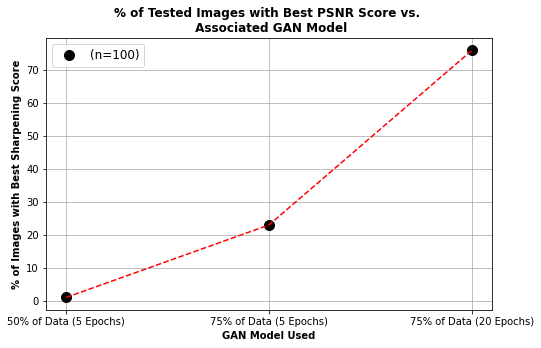

In [34]:
# Plot the percentage of images where each model achieved the best PSNR score:
x_labels = comparison_df.columns[:3].values
y_value = [final_counts[x] for x in x_labels]
plt.figure(figsize=(8,5))
plt.plot(x_labels, y_value, 'o', markersize=10, color='black')
plt.plot(x_labels, y_value, linestyle='dashed', color='red')
plt.xlabel("GAN Model Used", weight='bold')
plt.ylabel("% of Images with Best Sharpening Score", weight='bold')
plt.title("% of Tested Images with Best PSNR Score vs. \n Associated GAN Model", weight='bold', fontsize=12)
plt.grid(True)
plt.legend( [('(n={})'.format(len(comparison_df)))], fontsize=12)

From the plot above, it can be seen that the model trained on the larger 75% data fraction for 20 epochs has yielded the best PSNR sharpness score in 76% of the 100 images tested, in comparison to the two other models that were trained for 5 epochs.

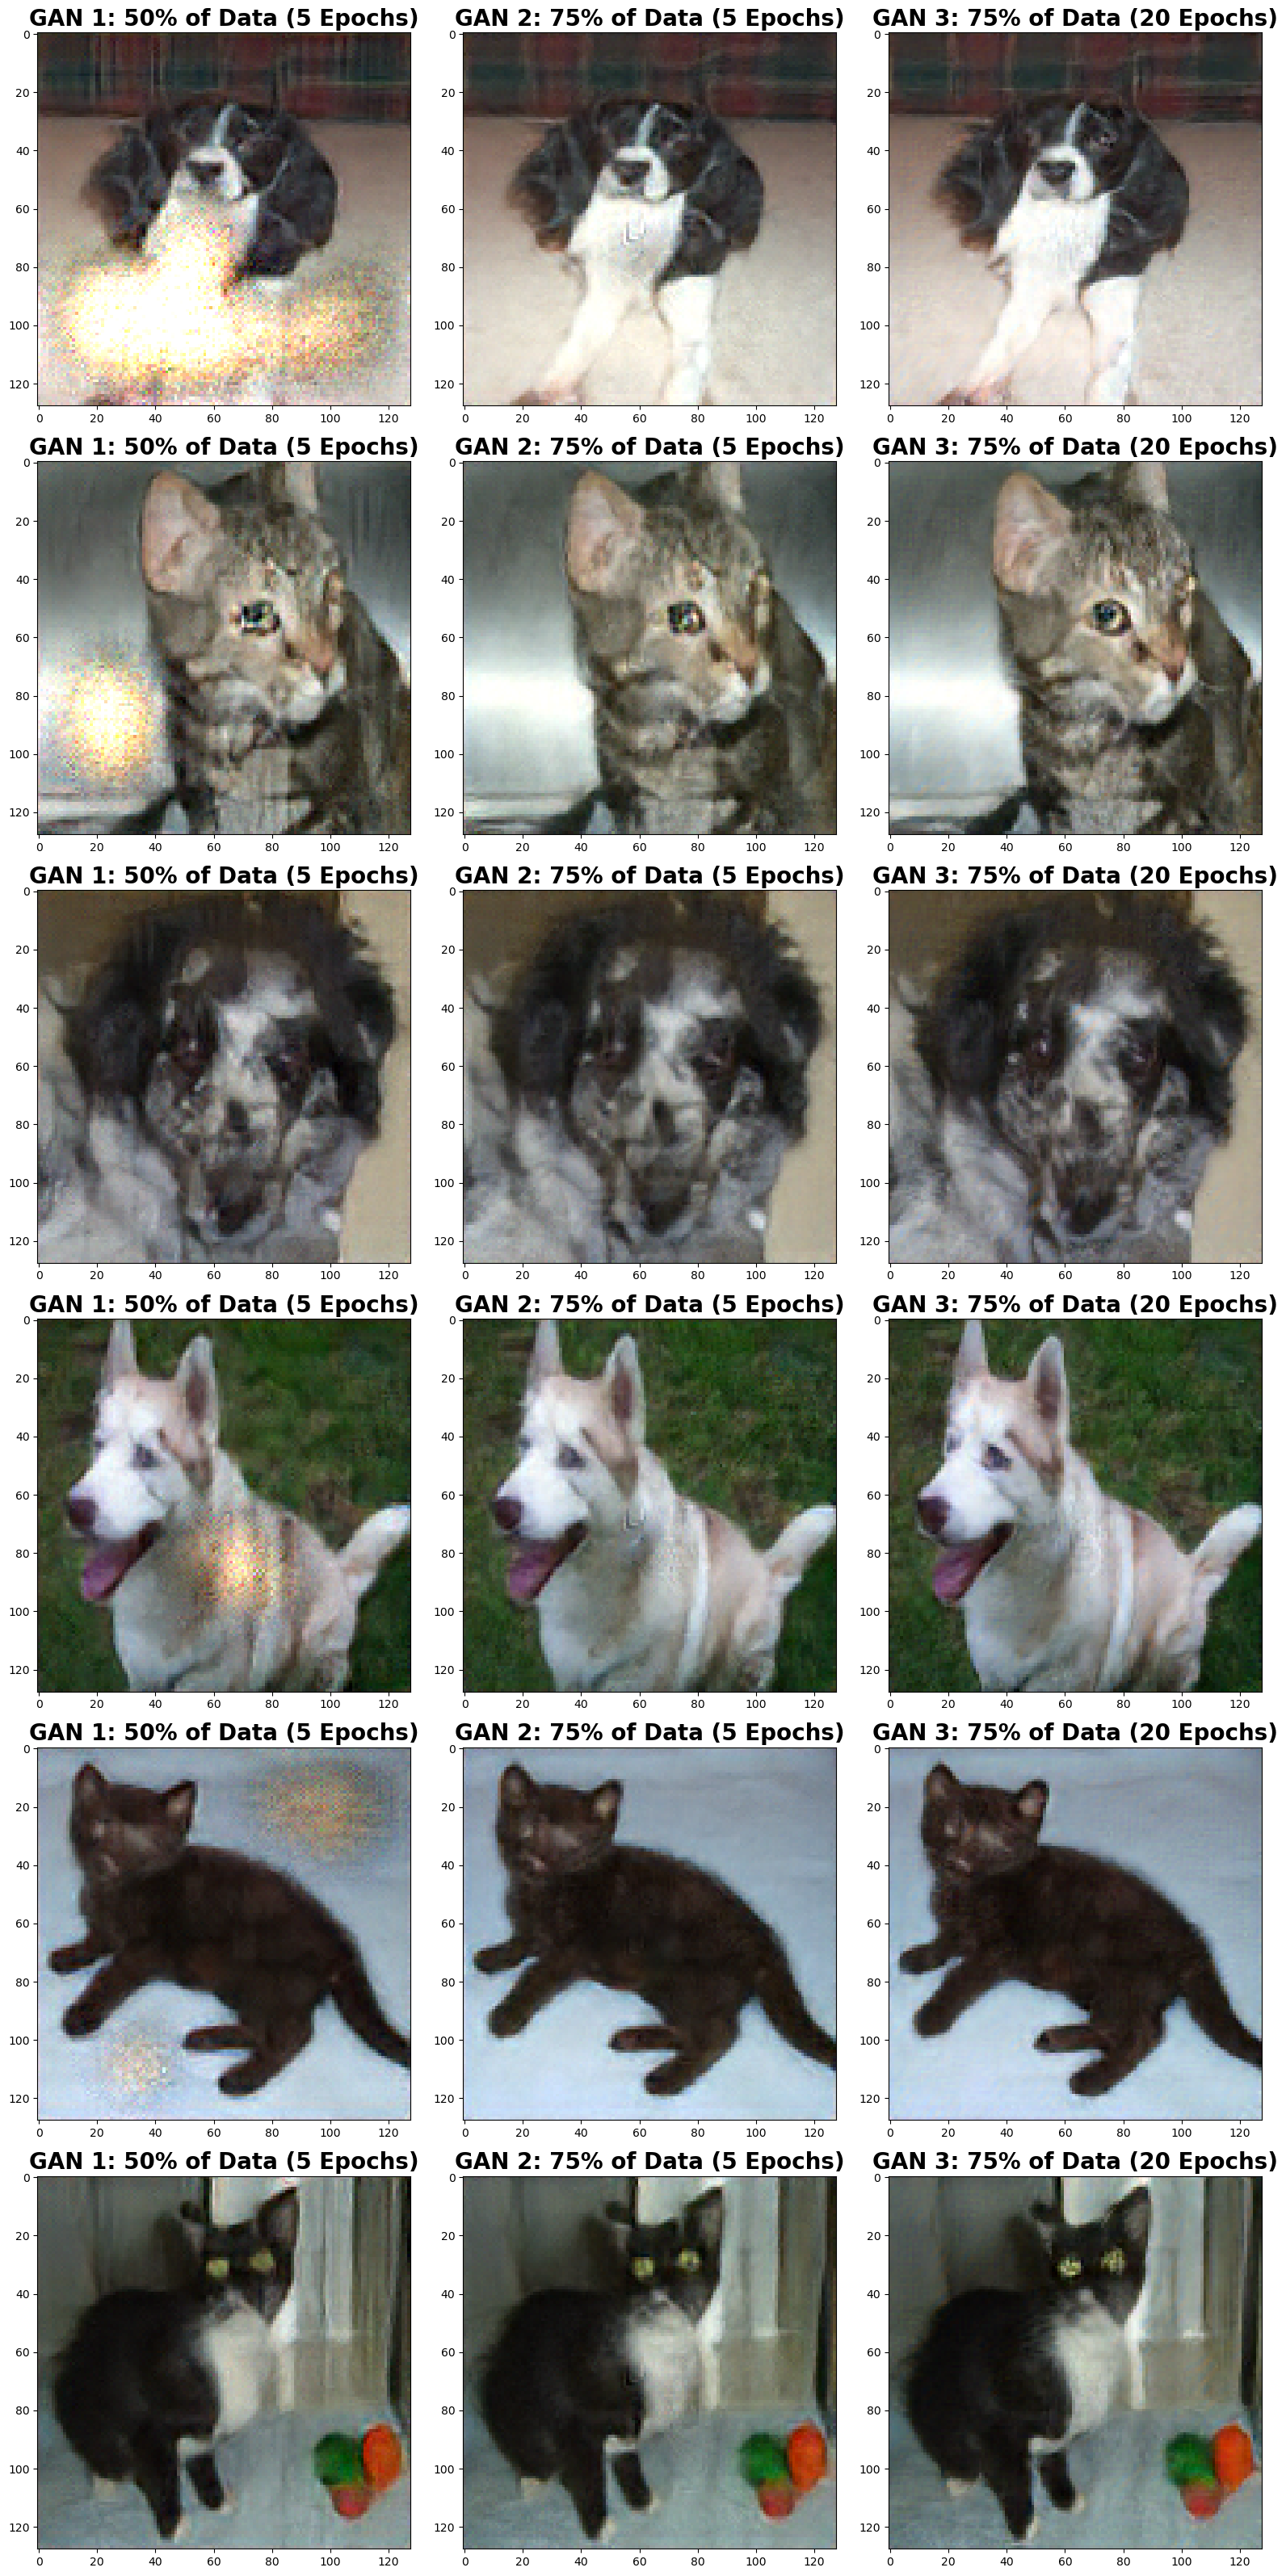

In [16]:
#Plot a few images from the three GANs that have been trained above:
fig, ax = plt.subplots(nrows=6,ncols=3, figsize=(16,32))
for image in range(0, 17, 3):  
    plt.subplot(6,3,image+1)
    plt.imshow(sharpened_image_sets[0][-20:][image])
    plt.title("GAN 1: 50% of Data (5 Epochs)", fontsize=20, fontweight='bold')
    plt.subplot(6,3,image+2)
    plt.imshow(sharpened_image_sets[1][-20:][image])
    plt.title("GAN 2: 75% of Data (5 Epochs)", fontsize=20, fontweight='bold')
    plt.subplot(6,3,image+3)
    plt.imshow(sharpened_images_final[-20:][image])
    plt.title("GAN 3: 75% of Data (20 Epochs)", fontsize=20, fontweight='bold')
    fig.tight_layout()

From the images above, it is clear that the GAN trained for 20 epochs on the larger amount of data has resulted in images that look sharper compared to the other 2 models. The final GAN model will now be used to sharpen the remaining unseen 5693 images in the cats vs dogs dataset. 
Then this SR cats vs dogs dataset can be exported to notebook 3 where it will be used to train several neural network image classifiers.

In [15]:
final_model = 'cat_dog_17077_images_trained_generator_20_epochs.h5'
path = '/kaggle/working/'+ final_model
generator = tf.keras.models.load_model(path)
print("Final Data Split:", final_split)
SR_cats_dogs = generator.predict((images_lr[final_split:]/255.0))
print(np.shape(SR_cats_dogs), np.min(SR_cats_dogs), np.max(SR_cats_dogs))

Final Data Split: 17077


2023-02-21 20:54:05.511273: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1119289344 exceeds 10% of free system memory.


(5693, 128, 128, 3) -0.37258664 1.5812365


Now that the remaining 5693 images in the cats vs dogs data has been sharpened, it can be seen that some of the pixel values extend beyond the range [0,1]. Therefore, the pixel values will be clipped so that they lie within this range in the next cell.

In [17]:
SR_cats_dogs = tf.clip_by_value(SR_cats_dogs, 0, 1)
print("SR_cats_dogs:", np.shape(SR_cats_dogs), ", Min:", np.min(SR_cats_dogs), ", Max:", np.max(SR_cats_dogs))

2023-02-21 20:54:52.782825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1119289344 exceeds 10% of free system memory.


SR_cats_dogs: (5693, 128, 128, 3) , Min: 0.0 , Max: 1.0


Now this dataset can be saved as an output from this notebook so it can be used in notebook 3 to train the SR neural network image classifiers.

In [19]:
# Save the sharpened SR cats vs dogs dataset:
np.savez("SR_cats_dogs", SR_cats_dogs)

# 5.TensorFlow Plot of Generator and Discriminator Neural Network Models
The graphical drawing of each neural network model will be displayed within this section, as this might help to visualise how the models are connected.

## 5.1 Discriminator Model Plot
The discriminator model plot is shown in the next cell. The model is a straightforward sequential model.

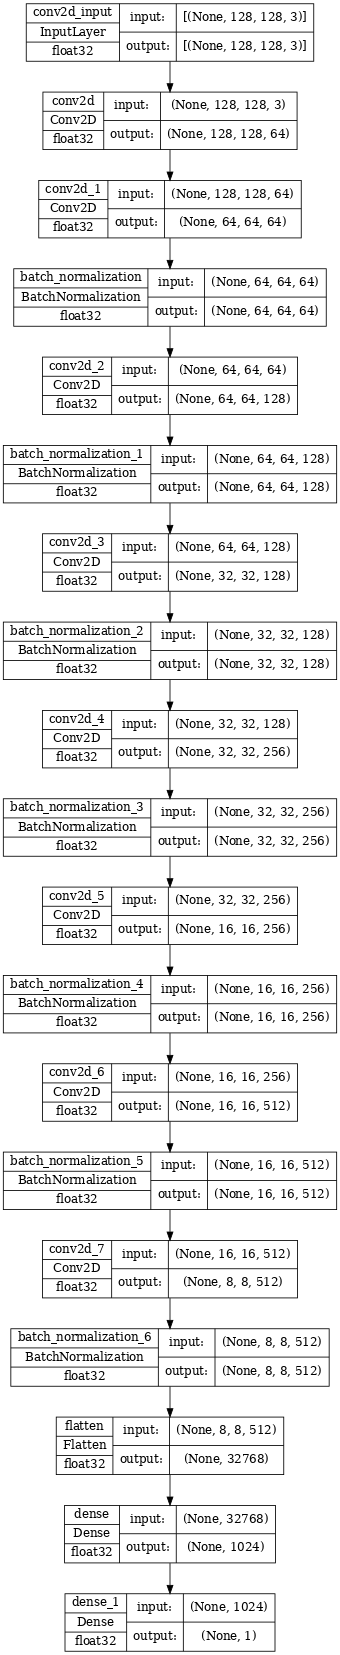

In [8]:
tf.keras.utils.plot_model(d_model, show_shapes=True, 
                          show_layer_names=True, show_dtype=True, dpi=60)

## 5.2 Generator Model Plot
The generator model contains skip connections, therefore it was created using the functional API.

In [7]:
tf.keras.utils.plot_model(generator_model, show_shapes=True, 
                          show_layer_names=True, show_dtype=True, dpi=60)

# 6. References 
* **[1]** Christian Ledig et al. Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network. CoRR, abs/1609.04802, 2017.
* **[2]** Sreenivas Bhattiprolu. Github - python for microscopists. https://github.com/bnsreenu/python_for_microscopists/tree/master/255_256_SRGAN, 2022.
* **[3]** Jeremy Lai Hong. Github - tensorflow2 implementation of srresnet and srgan. https://github.com/jlaihong/image-super-resolution, 2021.
* **[4]** Martín Abadi et al. TensorFlow tutorials: Deep convolutional generative adversarial network.
https://www.tensorflow.org/tutorials/generative/dcgan, 2015.